<a href="https://colab.research.google.com/github/theatharvagai/Weld-Defect-Detection-Hybrid-AI/blob/main/Final_code1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap lime imbalanced-learn

from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import numpy as np
import tensorflow as tf
import xgboost as xgb
import shap
import lime
import lime.lime_tabular
from tensorflow.keras import layers, models, Input
# CHANGE 1: Upgrade to B3 for better detail detection
from tensorflow.keras.applications import VGG19, EfficientNetB3, ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg_prep
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_prep
from tensorflow.keras.applications.resnet_v2 import preprocess_input as res_prep

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# CHANGE 2: Import SMOTE for feature balancing
from imblearn.over_sampling import SMOTE
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=1b3b1a166be4428755afa406c945309e74daa570099ebd8d17a1e88cfd4b4f44
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime
Mounted at /content/drive


In [ ]:


# ==========================================
# 1. PATH CONFIGURATION
# ==========================================
BASE_DIR = r"/content/drive/MyDrive/Model3"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")

SAVE_DIR = os.path.join(BASE_DIR, "Final_Ultra_Accuracy_Model")
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# PARAMS
IMG_SIZE = 300
BATCH_SIZE = 32
SEED = 42




In [ ]:
# ==========================================
# 2. HELPER FUNCTIONS (CLAHE ADDED)
# ==========================================
def apply_clahe(image):
    """
    CHANGE 3: Applies Contrast Limited Adaptive Histogram Equalization.
    This makes hidden cracks visible in X-rays before the AI sees them.
    """
    # Convert to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE to L-channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)

    # Merge and convert back to RGB
    limg = cv2.merge((cl, a, b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return final

def load_images_recursively(root_folder):
    paths = []
    labels = []
    if not os.path.exists(root_folder):
        return [], []

    valid_exts = ('.png', '.jpg', '.jpeg', '.bmp', '.tif')
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file.lower().endswith(valid_exts):
                paths.append(os.path.join(root, file))
                labels.append(os.path.basename(root))
    return paths, labels

print("\n--- Loading Data ---")
train_paths, train_labels = load_images_recursively(TRAIN_DIR)
val_paths, val_labels = load_images_recursively(VAL_DIR)
test_paths, test_labels = load_images_recursively(TEST_DIR)

if len(train_paths) == 0:
    raise ValueError(f"❌ No images found in {TRAIN_DIR}")

# Encode Labels
le = LabelEncoder()
y_train_enc = le.fit_transform(train_labels)
y_val_enc = le.transform(val_labels)
try:
    y_test_enc = le.transform(test_labels)
except ValueError:
    le.fit(train_labels + val_labels + test_labels)
    y_train_enc = le.transform(train_labels)
    y_val_enc = le.transform(val_labels)
    y_test_enc = le.transform(test_labels)

joblib.dump(le, os.path.join(SAVE_DIR, "label_encoder.joblib"))



--- Loading Data ---


['/content/drive/MyDrive/Model3/Final_Ultra_Accuracy_Model/label_encoder.joblib']

In [ ]:
# ==========================================
# 3. UPGRADED HYBRID MODELS
# ==========================================
print("\n--- Initializing Hybrid CNNs (Upgraded) ---")
# VGG19 (Good for Shapes)
model_vgg = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
pool_vgg = GlobalAveragePooling2D()

# EfficientNetB3 (Significant Upgrade from B0 - Better Texture)
model_eff = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
pool_eff = GlobalAveragePooling2D()

# ResNet50V2 (Good for Depth/Structure)
model_res = ResNet50V2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
pool_res = GlobalAveragePooling2D()

# ==========================================
# 4. FEATURE EXTRACTION (WITH CLAHE)
# ==========================================
def extract_features_advanced(paths):
    features = []
    print(f"   Extracting from {len(paths)} images...")

    for i in range(0, len(paths), BATCH_SIZE):
        batch_paths = paths[i : i + BATCH_SIZE]

        raw_imgs = []
        for p in batch_paths:
            img = cv2.imread(p)
            if img is None: continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # APPLY CLAHE HERE (Critical Step)
            img = apply_clahe(img)

            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            raw_imgs.append(img)

        if not raw_imgs: continue
        X_batch = np.array(raw_imgs, dtype=np.float32)

        # Split Preprocessing
        inp_vgg = vgg_prep(X_batch.copy())
        f1 = pool_vgg(model_vgg(inp_vgg, training=False))

        inp_eff = eff_prep(X_batch.copy())
        f2 = pool_eff(model_eff(inp_eff, training=False))

        inp_res = res_prep(X_batch.copy())
        f3 = pool_res(model_res(inp_res, training=False))

        combined = tf.concat([f1, f2, f3], axis=1)
        features.append(combined.numpy())

        if i % 500 == 0 and i > 0: print(f"   Processed {i}...")

    if len(features) == 0: return np.array([])
    return np.vstack(features)

print("--- Extracting Train ---")
X_train_raw = extract_features_advanced(train_paths)
print("--- Extracting Val ---")
X_val_raw = extract_features_advanced(val_paths)
print("--- Extracting Test ---")
X_test_raw = extract_features_advanced(test_paths)


--- Initializing Hybrid CNNs (Upgraded) ---
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
--- Extracting Train ---
   Extracting from 1820 images...
--- Extracting Val ---
   Extracting from 564 images...
--- Extracting Test ---
   Extracting from 549 images...


In [ ]:
# ==========================================
# 5. SCALING & SMOTE (BALANCING)
# ==========================================
print("\n--- Scaling Features ---")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_val_scaled = scaler.transform(X_val_raw)
X_test_scaled = scaler.transform(X_test_raw)
joblib.dump(scaler, os.path.join(SAVE_DIR, "scaler.joblib"))

print("\n--- Applying SMOTE (Synthetic Balancing) ---")
# This creates synthetic feature vectors for minority classes
# It is more effective for XGBoost than raw Image GANs
smote = SMOTE(random_state=SEED)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train_enc)

print(f"Original Train Size: {X_train_scaled.shape[0]}")
print(f"Balanced Train Size: {X_train_bal.shape[0]}")


--- Scaling Features ---

--- Applying SMOTE (Synthetic Balancing) ---
Original Train Size: 1820
Balanced Train Size: 1832


In [ ]:
# ==========================================
# 6. XGBOOST TRAINING
# ==========================================
print("\n--- Training XGBoost ---")
xgb_clf = xgb.XGBClassifier(
    n_estimators=2500, # Further reduced from 1000
    learning_rate=0.01,
    max_depth=3,       # Retaining this reduced value
    subsample=0.85,            # Slight increase
    colsample_bytree=0.85,     # Slight increase
    min_child_weight=1,        # Allow model to learn specific defects
    gamma=0.1,                 # Regularization to prevent overfitting
    objective='multi:softprob',
    eval_metric=['merror', 'mlogloss'],
    tree_method='hist',
    device='cuda',
    early_stopping_rounds=200, # Increased patience
    random_state=SEED
)

xgb_clf.fit(
    X_train_bal, y_train_bal, # Use Balanced Data
    eval_set=[(X_val_scaled, y_val_enc)],
    verbose=100
)



--- Training XGBoost ---
[0]	validation_0-merror:0.18440	validation_0-mlogloss:1.37274
[100]	validation_0-merror:0.13121	validation_0-mlogloss:0.67604
[200]	validation_0-merror:0.12234	validation_0-mlogloss:0.44254
[300]	validation_0-merror:0.10816	validation_0-mlogloss:0.34206
[400]	validation_0-merror:0.09220	validation_0-mlogloss:0.28909
[500]	validation_0-merror:0.08333	validation_0-mlogloss:0.25647
[600]	validation_0-merror:0.07979	validation_0-mlogloss:0.23511
[700]	validation_0-merror:0.07979	validation_0-mlogloss:0.22043
[800]	validation_0-merror:0.08156	validation_0-mlogloss:0.20930
[900]	validation_0-merror:0.08333	validation_0-mlogloss:0.20127
[1000]	validation_0-merror:0.08156	validation_0-mlogloss:0.19579
[1100]	validation_0-merror:0.08333	validation_0-mlogloss:0.19144
[1200]	validation_0-merror:0.08688	validation_0-mlogloss:0.18809
[1300]	validation_0-merror:0.08865	validation_0-mlogloss:0.18604
[1400]	validation_0-merror:0.08688	validation_0-mlogloss:0.18469
[1500]	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.85, device='cuda', early_stopping_rounds=200,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, feature_weights=None, gamma=0.1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2500, n_jobs=None,
              num_parallel_tree=None, ...)


--- Final Evaluation ---
🏆 FINAL ACCURACY: 92.17%

Classification Report:
                 precision    recall  f1-score   support

         Cracks       1.00      1.00      1.00       137
      Deposites       0.83      0.87      0.85       139
Discontinuities       1.00      1.00      1.00       136
         Stains       0.86      0.82      0.84       137

       accuracy                           0.92       549
      macro avg       0.92      0.92      0.92       549
   weighted avg       0.92      0.92      0.92       549



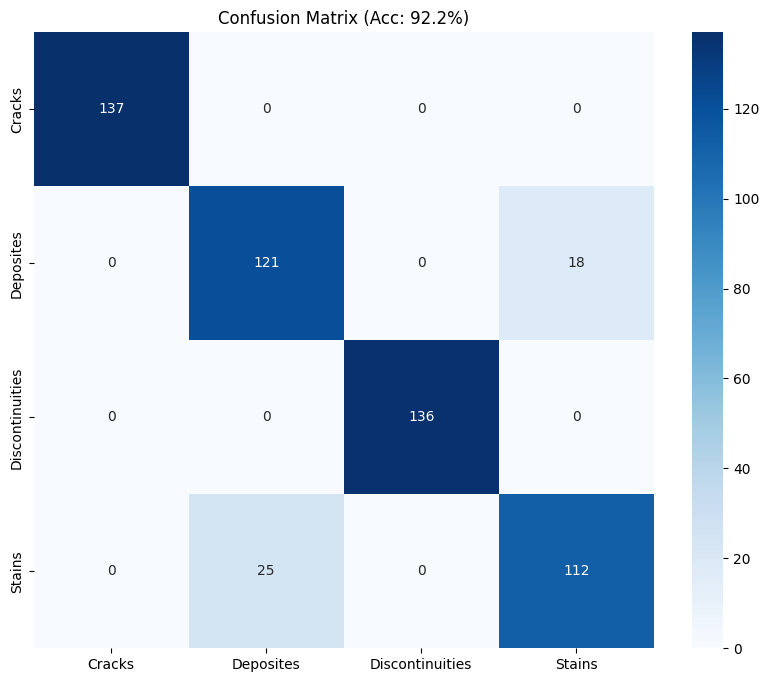

In [ ]:
# ==========================================
# 7. EVALUATION
# ==========================================
print("\n--- Final Evaluation ---")
y_pred = xgb_clf.predict(X_test_scaled)
acc = accuracy_score(y_test_enc, y_pred)
print(f"🏆 FINAL ACCURACY: {acc * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

plt.figure(figsize=(10,8))
cm = confusion_matrix(y_test_enc, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix (Acc: {acc*100:.1f}%)')
plt.show()


--- SHAP Analysis ---


<Figure size 640x480 with 0 Axes>

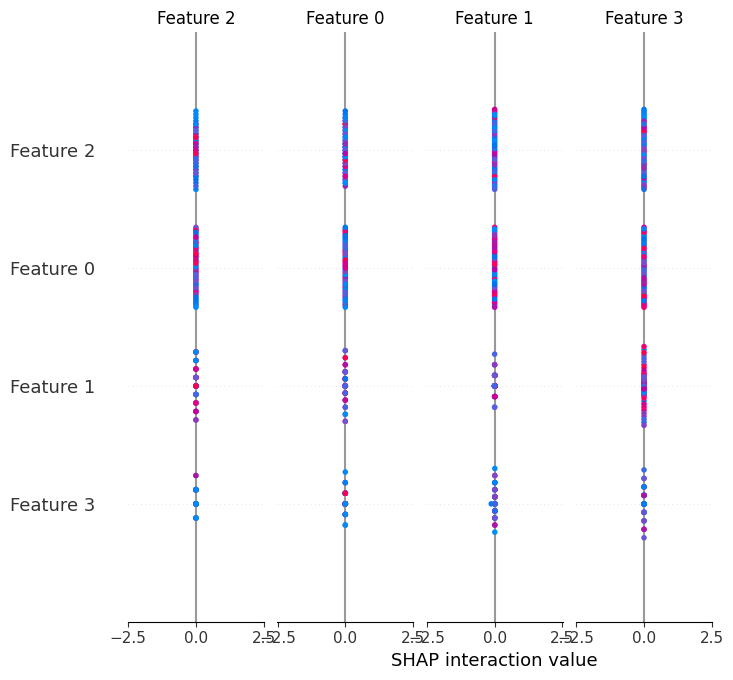


--- LIME Analysis ---

Saving Models to /content/drive/MyDrive/Model3/Final_Ultra_Accuracy_Model...


✅ All Processes Complete.


In [ ]:

# ==========================================
# 8. SHAP & LIME
# ==========================================
print("\n--- SHAP Analysis ---")
explainer = shap.TreeExplainer(xgb_clf)
shap_sample = X_test_scaled[:50]
shap_values = explainer.shap_values(shap_sample)

plt.figure()
shap.summary_plot(shap_values, shap_sample, class_names=le.classes_, show=False)
plt.savefig(os.path.join(SAVE_DIR, "shap_summary.png"))
plt.show()

print("\n--- LIME Analysis ---")
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_bal, # Use balanced training data for explainer
    mode='classification',
    class_names=le.classes_,
    discretize_continuous=True
)

idx = 0
exp = explainer_lime.explain_instance(
    data_row=X_test_scaled[idx],
    predict_fn=xgb_clf.predict_proba,
    num_features=10
)
exp.save_to_file(os.path.join(SAVE_DIR, "lime_explanation.html"))

# ==========================================
# 9. SAVE MODELS
# ==========================================
print(f"\nSaving Models to {SAVE_DIR}...")
xgb_clf.save_model(os.path.join(SAVE_DIR, "XGBoost_Classifier.json"))

inp = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
out = Concatenate()([
    GlobalAveragePooling2D()(VGG19(weights=None, include_top=False, input_tensor=inp).output),
    GlobalAveragePooling2D()(EfficientNetB3(weights=None, include_top=False, input_tensor=inp).output), # Note B3
    GlobalAveragePooling2D()(ResNet50V2(weights=None, include_top=False, input_tensor=inp).output)
])
Model(inputs=inp, outputs=out).save(os.path.join(SAVE_DIR, "Final_Hybrid_Extractor.h5"))

print("✅ All Processes Complete.")